# Fast Agent - Build a SQL Agent fast!

<img src="./assets/LC_L1_top.png" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [1]:
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env("example.env")  # check environmental variables
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # check packages

OPENAI_API_KEY=****hPcA
LANGSMITH_API_KEY=****a745
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
Python 3.12.1 satisfies requires-python: >=3.11,<3.14
package                | required | installed | status | path                                                                            
---------------------- | -------- | --------- | ------ | --------------------------------------------------------------------------------
langgraph              | >=1.0.0  | 1.0.1     | ✅ OK   | /workspaces/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain              | >=1.0.0  | 1.0.2     | ✅ OK   | /workspaces/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain-core         | >=1.0.0  | 1.0.1     | ✅ OK   | /workspaces/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain-openai       | >=1.0.0  | 1.0.1     | ✅ OK   | /workspaces/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain-anthrop

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [27]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# # define context structure to support dependency injection
# @dataclass
# class RuntimeContext:
#     db: SQLDatabase

from langchain_community.utilities.github import GitHubAPIWrapper
#.github_wrapper import GitHubAPIWrapper






<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [16]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"



# from langchain_core.tools import tool
# from github_wrapper import GitHubAPIWrapper  # your class

# # Initialize the wrapper
# github = GitHubAPIWrapper(
#     github_repository="myuser/myrepo",
#     github_app_id="YOUR_APP_ID",
#     github_app_private_key="YOUR_PRIVATE_KEY"
# )

# @tool
# def github_action(mode: str, query: str = "") -> str:
#     """
#     Call the GitHub wrapper's methods via 'mode'.
#     Example modes: get_issues, create_pull_request, list_branches_in_repo, read_file, etc.
#     """
#     try:
#         return github.run(mode, query)
#     except Exception as e:
#         return f"Error: {e}"


ModuleNotFoundError: No module named 'github_wrapper'

Add a system prompt to define your agents behavior.

In [5]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list. 

In [6]:
from langchain.agents import create_agent
from langchain_google_genai import ChatGoogleGenerativeAI
my_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    max_tokens=None,
    temperature=0 # Lower temperature for stable, factual SQL generation
)#new

agent = create_agent(
    #model="openai:gpt-5-mini"
    model=my_llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

Here's a display of the agent ReAct Loop.

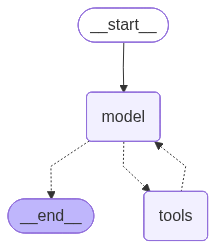

In [7]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [11]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    config={"recursion_limit": 50},
    context=RuntimeContext(db=db),
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (b3622758-c4ed-445b-9605-13d49a5b623d)
 Call ID: b3622758-c4ed-445b-9605-13d49a5b623d
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (9f096c1a-13c6-49c0-91ee-c9d8de901e77)
 Call ID: 9f096c1a-13c6-49c0-91ee-c9d8de901e77
  Args:
    query: SELECT COUNT(*) FROM Album;
================================= Tool Message =================================
Name: execute_sql

[(347,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (4808ea5a-f0bb-4ce0-b1bd-0fcb91ca157e)
 Call ID: 4808ea5a-f0bb-4ce0-b1bd-0fcb91ca157e
  Args:
    query: SELECT COUNT(*) FROM Artist;
================================= Tool Message =================================
Name: execute_sql

[(275,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (a9075f40-3a9a-4cbb-92f1-1790fbaa3778)
 Call ID: a9075f40-3a9a-4cbb-92f1-1790fbaa3778
  Args:
    query: SELECT COUNT(*) FROM Customer;
================================= Tool Message =================================
Name: execute_sql

[(59,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (aea31a26-70bf-41a3-ac09-3bbdf4ff0e99)
 Call ID: aea31a26-70bf-41a3-ac09-3bbdf4ff0e99
  Args:
    query: SELECT COUNT(*) FROM Employee;
================================= Tool Message =================================
Name: execute_sql

[(8,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (f7bdb3a2-1c3e-46c9-8cd8-1d530fd10f59)
 Call ID: f7bdb3a2-1c3e-46c9-8cd8-1d530fd10f59
  Args:
    query: SELECT COUNT(*) FROM Genre;
================================= Tool Message =================================
Name: execute_sql

[(25,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (363460ed-044e-4155-a121-2fa0d7cd2140)
 Call ID: 363460ed-044e-4155-a121-2fa0d7cd2140
  Args:
    query: SELECT COUNT(*) FROM Invoice;
================================= Tool Message =================================
Name: execute_sql

[(412,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (b18f7e6e-cba8-4473-a7e4-1035fa59a38e)
 Call ID: b18f7e6e-cba8-4473-a7e4-1035fa59a38e
  Args:
    query: SELECT COUNT(*) FROM InvoiceLine;
================================= Tool Message =================================
Name: execute_sql

[(2240,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (2ec0965a-4ef1-4524-bff1-782fdcddf2e3)
 Call ID: 2ec0965a-4ef1-4524-bff1-782fdcddf2e3
  Args:
    query: SELECT COUNT(*) FROM MediaType;
================================= Tool Message =================================
Name: execute_sql

[(5,)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (ca7701df-3a6b-4cd7-9a38-ee548abc2872)
 Call ID: ca7701df-3a6b-4cd7-9a38-ee548abc2872
  Args:
    query: SELECT COUNT(*) FROM Playlist;
================================= Tool Message =================================
Name: execute_sql

[(18,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 7.709507537s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativela

================================== Ai Message ==================================
Tool Calls:
  execute_sql (2adbe24b-b919-49d6-bcbe-95eff476d8d1)
 Call ID: 2adbe24b-b919-49d6-bcbe-95eff476d8d1
  Args:
    query: SELECT COUNT(*) FROM PlaylistTrack;
================================= Tool Message =================================
Name: execute_sql

[(8715,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 5.66620662s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelan

================================== Ai Message ==================================
Tool Calls:
  execute_sql (795105df-9eb3-4aed-9b52-5ff921f6b2ad)
 Call ID: 795105df-9eb3-4aed-9b52-5ff921f6b2ad
  Args:
    query: SELECT COUNT(*) FROM Track;
================================= Tool Message =================================
Name: execute_sql

[(3503,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'type': 'text', 'text': 'The table with the largest number of entries is `PlaylistTrack` with 8715 entries.', 'extras': {'signature': 'CpgEAdHtim+V/BwJCKSvK8kjUo6VVfyc4hiXt+dp1yDG9iZ9rGuLe8kD2KFNGEpLQEwjXsvCHtAodSF5mHIO4dRnvIAuyNtrYbnTdyJJxU88/9bgPcUtwlOMQz3Kqc3/5C5BTVIR0iStZBdnemuz2Mfb5fJCzY5r4yWNj9GyzrhYDc/J5bUr7usGdOhLDeDY0gic7SY+OWfuaYC32f2iiOKwlZfoSOFufFDZxaPziwo+9JNpOYmgoDrPIvDgRpEAjrxK+SoIJWl9h58/WIfMocw7RPs0aYLx0GbTRvAwTGTz7symiSDUKmn7cy4HJ9Yz6F6VSb4M7u6hLyLA5NrdTMx4Ia/mu4smSUBuapqaUHUcl4Rc2UvjkH3j53vcI009nJeFUAV9CI071nTVaGoZdP4ZZksr9GlaGzFfD7enLYq2GhWiikCzjr0R3K0Rz8rYDnkbPxU1FPqruHnDKUvJt8UI7czVchHa5s7upiGTIUXCgYdIJaLN3m+HIDJxdm/WV/pYF8ri28JNKO7IbJP5ikKPxjnO08cJ+dzEhzfb6W7rJDJA3XFzyeIGAqFmfyXWssC2PPgzCYxCMsfgA/SEF5t6zeWAN4427Y5A77yat0ShVOhXtSELcqYl1TPoz5V9BIIzGANTBUsPFRaIiUCvugtj/XDuEeBW6TOViimFTP9AZmR6g8AgJcNjh8NGxzenklFMbLiGb7GwL6A='}}]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [13]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    config={"recursion_limit": 50},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (93b49e24-ca9a-4805-9f3d-47783a44de67)
 Call ID: 93b49e24-ca9a-4805-9f3d-47783a44de67
  Args:
    query: SELECT T2.Name, AVG(T1.Milliseconds) AS AverageTrackLength FROM tracks AS T1 INNER JOIN genres AS T2 ON T1.GenreId = T2.GenreId GROUP BY T2.Name ORDER BY AverageTrackLength DESC LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT T2.Name, AVG(T1.Milliseconds) AS AverageTrackLength FROM tracks AS T1 INNER JOIN genres AS T2 ON T1.GenreId = T2.GenreId GROUP BY T2.Name ORDER BY AverageTrackLength DESC LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (ab10910f-9062-4754-9279-0b5e76964387)
 Call ID: ab10910f-9062-4754-9279-0b5e76964387
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (daecf978-1586-4cbf-b974-37d94c1bbd99)
 Call ID: daecf978-1586-4cbf-b974-37d94c1bbd99
  Args:
    query: SELECT T2.Name, AVG(T1.Milliseconds) AS AverageTrackLength FROM Track AS T1 INNER JOIN Genre AS T2 ON T1.GenreId = T2.GenreId GROUP BY T2.Name ORDER BY AverageTrackLength DESC LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

[('Sci Fi & Fantasy', 2911783.0384615385)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'type': 'text', 'text': 'The genre with the longest average track length is Sci Fi & Fantasy.', 'extras': {'signature': 'CpcEAdHtim9nfA6lUJU+PYtCHngJjAV9+O4Zy/vRSSIjNkvz2rvie/H9S/yMOkERUuDN+qCo2Ipg8TDK3SVgAg9fznalg98JENeitZTyiugILCoowSiQqPj9zaTIlhR0x4TXkh5Kr7JiZ7nyHKjw5d2B/qL4BmCidzjWy1EdxStyQT3DX9kJy8fqyQNnO9ovdf1GTVd02wvcD64MDi4Vhb5g/XkvEMEbm5bKkuy6lCLNdM2mrhlQTkE2jTpSECx9iHVfmmbLlC/tFd3ERYItqp4XAPtKS/ZFN2cnNyS4YTz7Ubf6Yh6P2ITHPppZxVCujFR0nDlm4sNTzF29zJDsTQEbjU4onDxXZWz+yRRswWtdtvpX0M8DOk2a7AkyFD95mDGAq8o91Krt7g59ihCNC6NDAFlR9Xzilo1PwWNWNwFJV69nR5Kt6MwUL9xzDhjp8Ypkf8SVyME688OXUFsv2ptkGNsahvCPKqsoV+g7ihlviu1KygXO9QqpTTuXRbQyK5Hud/6QoBH8eD/Dd32NlE7PFsa2RFanau16Ffo+bGXi4NL+1l/9OpGXt75tyb8zLSLO+SM3Al0y2XJExSg2RiVQSekOPHoTi/anG6vQMCZ7LOWC3KMRv/y6ZOzSW6WThYQip0kBRA9seXXFAMX3ZLQGf+48fPgDZGd6WTDPrJMzyUA9IruynESAQJeJrX8dQtJ1deFat5uQjg=='}}]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [14]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    config={"recursion_limit":50},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (6e3c615f-4123-4fbf-9c5e-628da9e40df0)
 Call ID: 6e3c615f-4123-4fbf-9c5e-628da9e40df0
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

The tables are: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


**Create your own query here!**  Add some questions of your own.

In [15]:
question = "How many records are available"

for step in agent.stream(
    {"messages": question},
    config={"recursion_limit":50}, #added this to increaese recursion limit
    #because it showed when it reached the default limit of 25 step without arriving at a
    #final answer
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many records are available


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (826e33bb-16fa-4b0a-8d1b-63505d5c351b)
 Call ID: 826e33bb-16fa-4b0a-8d1b-63505d5c351b
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (7a14314a-cfac-4fd1-a481-aa6de2f47d2c)
 Call ID: 7a14314a-cfac-4fd1-a481-aa6de2f47d2c
  Args:
    query: SELECT COUNT(*) FROM Album;
================================= Tool Message =================================
Name: execute_sql

[(347,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (9fa23644-1172-4ebb-a281-c3bd54281b5d)
 Call ID: 9fa23644-1172-4ebb-a281-c3bd54281b5d
  Args:
    query: SELECT COUNT(*) FROM Artist;
================================= Tool Message =================================
Name: execute_sql

[(275,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (a55dc071-42df-428f-8c44-168dc1527867)
 Call ID: a55dc071-42df-428f-8c44-168dc1527867
  Args:
    query: SELECT COUNT(*) FROM Customer;
================================= Tool Message =================================
Name: execute_sql

[(59,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (bde819c6-ac4f-4608-b7d0-ddeee81569d6)
 Call ID: bde819c6-ac4f-4608-b7d0-ddeee81569d6
  Args:
    query: SELECT COUNT(*) FROM Employee;
================================= Tool Message =================================
Name: execute_sql

[(8,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (1505795b-882d-4e9d-b9ba-424c2615cdbe)
 Call ID: 1505795b-882d-4e9d-b9ba-424c2615cdbe
  Args:
    query: SELECT COUNT(*) FROM Genre;
================================= Tool Message =================================
Name: execute_sql

[(25,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (8b300525-8612-4430-81ba-5d44c0957322)
 Call ID: 8b300525-8612-4430-81ba-5d44c0957322
  Args:
    query: SELECT COUNT(*) FROM Invoice;
================================= Tool Message =================================
Name: execute_sql

[(412,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (8655d8e5-f98b-4184-8e99-3ef00f204b52)
 Call ID: 8655d8e5-f98b-4184-8e99-3ef00f204b52
  Args:
    query: SELECT COUNT(*) FROM InvoiceLine;
================================= Tool Message =================================
Name: execute_sql

[(2240,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 23.199404969s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativel

================================== Ai Message ==================================
Tool Calls:
  execute_sql (69d372af-4f7c-449e-ae34-334131acbc04)
 Call ID: 69d372af-4f7c-449e-ae34-334131acbc04
  Args:
    query: SELECT COUNT(*) FROM MediaType;
================================= Tool Message =================================
Name: execute_sql

[(5,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 21.157067142s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativel

================================== Ai Message ==================================
Tool Calls:
  execute_sql (d0594410-31aa-4f0b-811c-1e463c894ede)
 Call ID: d0594410-31aa-4f0b-811c-1e463c894ede
  Args:
    query: SELECT COUNT(*) FROM Playlist;
================================= Tool Message =================================
Name: execute_sql

[(18,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Tool Calls:
  execute_sql (a49ca28e-7767-4748-b4c8-a4491eca2d5a)
 Call ID: a49ca28e-7767-4748-b4c8-a4491eca2d5a
  Args:
    query: SELECT COUNT(*) FROM PlaylistTrack;
================================= Tool Message =================================
Name: execute_sql

[(8715,)]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'type': 'text', 'text': 'There are:\n- 347 records in the Album table\n- 275 records in the Artist table\n- 59 records in the Customer table\n- 8 records in the Employee table\n- 25 records in the Genre table\n- 412 records in the Invoice table\n- 2240 records in the InvoiceLine table\n- 5 records in the MediaType table\n- 18 records in the Playlist table\n- 8715 records in the PlaylistTrack table', 'extras': {'signature': 'CuMBAdHtim+jLZL6piNTfJ80WxpKoZblUQhVLXETDeALNaNULDeaIL8g6fQQAsDIg8bf28hOlk+54Mx8H9FYC4FIzyi3vgfwphnRs4vaCZ3CyNHMeeYWdyHPrtftnkU2CwelwyAPAyRLsKMP+Wgw3o6ednx+wa4G8J1+d8pBo+SRepT3V456Q7c57KNJMFgs0ya/F8eKMhVK74mBkj+JqBjyfUFxK3/wFOfN8xzu7O/+BVy3a//9uaywjvChY4nsvJnRoGvKvv15iJXl+12wrW8rsuNfMHKT3CztfUx+QLo5GXHZZOs='}}]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### Let's try this Studio